## **Libraries and Packages:**

Install the following if you havent yet

In [9]:
!pip install torch_geometric
!pip install rdkit
!pip install nx
!pip install kora py3Dmol

In [10]:
import torch
import os
import torch_geometric
import rdkit

import torch.nn as nn
import torch_geometric.nn as gnn
import pandas as pd
import numpy as np

from rdkit import Chem
import kora.install.rdkit
from rdkit.Chem import Draw
from IPython.display import display
from rdkit.Chem import AllChem
import py3Dmol

import networkx as nx
from torch_geometric.data import InMemoryDataset, Dataset
from torch_geometric.data import DataLoader
from torch_geometric import data as DATA
from google.colab import drive
import shutil
import math


In [11]:
  print(f'Torch version: {torch.__version__}')
  print(f'Torch_geometric version: {torch_geometric.__version__}')
  print(f'Pandas version: {pd.__version__}')
  print(f'Numpy version: {np.__version__}')
  print(f'Rdkit version: {rdkit.__version__}')
  print(f'Network version: {nx.__version__}')


Torch version: 2.8.0+cu126
Torch_geometric version: 2.7.0
Pandas version: 2.2.2
Numpy version: 2.0.2
Rdkit version: 2025.09.1
Network version: 3.5


## **Helper Classes:**

In [12]:
class ECFP(): # ECFP: Extended Connectivity Finger Prints for Chemeoinformatics
  def __init__(self):
    super().__init__()
    self.chem_symbols = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na',
                       'Ca','Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb',
                       'Sn', 'Ag','Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge',
                       'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']
    self.bond_types = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]



  def identifier(self, mol, radius):
    hashed_atoms = dict()

    # 1: Initial stage
    for atom in mol.GetAtoms():
      info = (atom.GetDegree(), atom.GetTotalValence()-atom.GetTotalNumHs(), atom.GetAtomicNum(),
                int(atom.GetMass()), atom.GetFormalCharge(), atom.GetTotalNumHs(), int(atom.GetIsAromatic()))
      h = hash(info)
      hashed_atoms[atom.GetIdx()] = [h]

    # 2: Updating state
    for i in range(radius-1):

      for index, hash_val in hashed_atoms.items():
        init_identifier = hash_val[-1]
        curr_atom = mol.GetAtoms()[index]
        iter_num = index+1

        neighbor_info = list()
        for n in curr_atom.GetNeighbors():
          n_index = n.GetIdx()
          n_bond = mol.GetBondBetweenAtoms(curr_atom.GetIdx(), (n_index))
          n_bond_type = str(n_bond.GetBondType())
          bond_order = self.bond_types.index(n_bond_type) + 1
          hashed_nieghbor = hashed_atoms[n_index][i]  # we want to consider the calculations from the previous radius
          neighbor_info.append((bond_order, hashed_nieghbor))
        neighbor_info.sort(key=lambda x: x[1])

        new_identifier = [i +1, init_identifier]
        for feats in neighbor_info:
            new_identifier.append(feats[0])
            new_identifier.append(feats[1])
        hashed_atoms[index].append(hash(tuple(new_identifier)))
    return hashed_atoms



  def node_features(self, mol, radius):
    # 3: Reduction stage
    ids = self.identifier(mol, radius)
    encoded_feats = list()


    for index, hashed_props in ids.items():
      binary_form = ""
      for ecfp in hashed_props:
        binary_form += format(abs(ecfp), 'b').ljust(64, '0')
      bin_feature_vec = np.array([int(char) for char in binary_form])

      assert len(bin_feature_vec) == (4 * 64)

      atom = mol.GetAtoms()[index]
      atomic_feats = np.array(list(map(lambda a: (self.chem_symbols[-1]  if atom.GetSymbol() not in self.chem_symbols else atom.GetSymbol()) == a, self.chem_symbols))
                              + list(map(lambda a: atom.GetDegree() == a, np.arange(0, 11, 1)))
                              + list(map(lambda a: (10  if atom.GetTotalNumHs() not in list(range(11)) else atom.GetTotalNumHs()) == a, np.arange(0, 11, 1)))
                              + list(map(lambda a: (10  if atom.GetValence(Chem.rdchem.ValenceType.IMPLICIT) not in list(range(11)) else atom.GetValence(Chem.rdchem.ValenceType.IMPLICIT)) == a, np.arange(0, 11, 1)))
                              + [atom.GetIsAromatic()])

      encoded_feats.append(np.concatenate((bin_feature_vec, atomic_feats), axis = 0))
    return  encoded_feats


In [13]:
class custom_DataLoader(InMemoryDataset):
  def __init__(self, root, xd=None, xc=None, y=None, drug_graph=None, drug_list=None, cells_list=None, transform = None, pre_transform = None):
    super().__init__(root, transform, pre_transform)

    self.dataset = root.split('/')[-1]
    if os.path.isfile(self.processed_paths[0]):
      self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
    else:
      self.process(xd, xc, y, drug_graph, drug_list, cells_list)
      self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
      # weights_only =False is only possible because the data sets are obtained from a trusted source

  @property
  def raw_file_names(self):
    pass

  @property
  def processed_file_names(self):
    return [self.dataset + '.pt']

  def _process(self):
    if not os.path.exists(self.processed_dir):
      os.makedirs(self.processed_dir)

  # def len(self):
  #       return len(self.processed_file_names)

  # def get(self, idx):
  #   data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
  #       return data

  def process(self, xd, xc, y, drug_graph, drug_list, cells_list):
    assert (len(xd) == len(xc) and len(xc) == len(y)), f"xd (len: {len(xd)}), xc(len: {len(xc)}), and ic50_list (len: {len(y)}) must all be the same size"
    data_lst = list()
    for i in range(len(xd)):
        smiles = xd[i]
        target = xc[i]
        labels = y[i]

        drug_names = drug_list[i]
        cell_names = cells_list[i]
        size, features, edge_index, bond_feats, graph = drug_graph[smiles]

        GCNData = DATA.Data(x=torch.Tensor(np.array(features)),
                            edge_index=torch.LongTensor(np.array(edge_index)).transpose(1, 0),
                            edge_features=torch.Tensor(np.array(bond_feats)),
                            y=torch.FloatTensor([labels]),
                            smiles=smiles,
                            drug_name=drug_names,
                            cell_line_name=cell_names
                            )


        # GCNData.target = torch.FloatTensor([target])
        GCNData.target = torch.from_numpy(target).float()


        GCNData.__setitem__('size', torch.LongTensor([size]))
        data_lst.append(GCNData)

    data, slices = self.collate(data_lst)
    torch.save((data, slices), self.processed_paths[0])



## **Data Processing**


In [14]:
# ecfp_radius = 4
def drug_data_to_graph(filepath, ecfp_radius, consider_edge_features = True):

  assert filepath.endswith(".csv"), "Ensure file ends in .csv"
  drug_df = pd.read_csv(filepath, skiprows=1, header=None)
  drug_graph = dict()
  algo = ECFP()
  smiles = list()
  drugs = dict()

  for drug in drug_df.itertuples(index=False):
    name = drug[0]
    smile = drug[2]

    smiles.append(smile)
    drugs[name] = len(drugs)

    if (smile == "N.N.[Cl-].[Cl-].[Pt+2]"):
      continue
    else:
      molecule = Chem.MolFromSmiles(smile)
      size = molecule.GetNumAtoms()
      features = algo.node_features(molecule, ecfp_radius)

      edge_dict = dict()
      edges = list()
      bond_feats = list()

      for bond in molecule.GetBonds():
        edges.append ([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        b = algo.bond_types.index(str(bond.GetBondType()))

        # generating relational molecular graph
        edge_dict[(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())] = np.array([b])
        edge_dict[(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())] = np.array([b])

    graph = nx.Graph(edges).to_directed()
    edge_index = []
    for a, b in graph.edges:
      edge_index.append([a,b])
      bond_feats.append(edge_dict[(a,b)])

    drug_graph[smile] = (size, features, edge_index, bond_feats, graph)

  return smiles, drugs, drug_graph

In [15]:
def load_genetic_data(genetic_filepath, cell_line_filepath, landmark_filepath, samples_data, use_landmark_genes, graph_info):
  assert genetic_filepath.endswith(".csv"), "Ensure file ends in .csv"
  assert cell_line_filepath.endswith(".csv"), "Ensure file ends in .csv"


  genetic_df = pd.read_csv(genetic_filepath, skiprows=1, header=None)
  cell_line_df = pd.read_csv(cell_line_filepath, index_col=0, header=0)
  landmark_genes_df = pd.read_csv(landmark_filepath, sep= '\t', header=0)
  samples = pd.read_csv(samples_data, header = 0)


  if use_landmark_genes:
    lg = landmark_genes_df['Symbol'].values
    cell_line_df.columns = [c.split(' (')[0] for c in cell_line_df] # rename the columns
    gene_names = cell_line_df.columns.values
    genes_OI = np.intersect1d(lg, gene_names)
    g_exp_OI = cell_line_df[genes_OI]
  else:
    cell_line_df = cell_line_df.loc[:, (cell_line_df == 0).sum() < cell_line_df.shape[0]*0.1]
    exp_var = cell_line_df.var()
    exp_var_arr = np.array(exp_var)
    rank = np.flip(np.argsort(exp_var_arr)) # returns sorted index of var values
    g_exp_OI = cell_line_df.iloc[:, rank[:1_000]]

  samples = samples[samples["COSMICID"].notna()]
  drop_columns = [col for col in samples.columns if col != "COSMICID"]
  gene_expression =  g_exp_OI.merge(samples, left_index=True, right_on="DepMap_ID").drop(columns=drop_columns, axis=1)
  gene_expression["COSMICID"] = gene_expression['COSMICID'].astype(int).astype(str)
  gene_expression.set_index('COSMICID', inplace=True)

  cells = gene_expression.index.values
  cell_dict = dict()
  for c in cells:
    index = np.where(cells == c)[0]
    cell_dict[int(c)] = index
  cell_feats = gene_expression.values
  genes = gene_expression.columns

  # here we read the pancreatic cancer line
  smiles = graph_info[0]
  drugs = graph_info[1]

  drug_cell_pairs = np.zeros((len(drugs), len(cell_dict)))
  xd = list()
  xc = list()
  ic50_list = list()

  drug_list = list()
  cells_list = list()

  for info in genetic_df.itertuples(index=False):
    drug = info[0]
    cell = info[3]

    # how much of a substance is needed to inhibit a specific biological process
    ic50 = 1 / (1 + (math.exp(float(info[8])) ** -0.1))

    if drug in drugs and cell in cell_dict:

      xd.append(smiles[drugs[drug]])
      xc.append(cell_feats[cell_dict[cell]])
      ic50_list.append(ic50)
      drug_cell_pairs[drugs[drug], cell_dict[cell]] += 1
      drug_list.append(drug)
      cells_list.append(cell)


  return np.asarray(xd), np.asarray(xc), np.asarray(ic50_list), np.asarray(drug_list), np.asarray(cells_list), drug_cell_pairs

## **Generating Datasets:**

In [16]:
def generate_datasets(root, xd, xc, y, drug_list, cells_list, drug_cell_pairs, drug_graph, seed=19871731, blind_testing=True):

  if blind_testing:

    np.random.seed(seed)
    np.random.shuffle(xd)

    np.random.seed(seed)
    np.random.shuffle(xc)

    np.random.seed(seed)
    np.random.shuffle(y)

    np.random.seed(seed)
    np.random.shuffle(drug_list)

    np.random.seed(seed)
    np.random.shuffle(cells_list)

    split = int(xd.shape[0] * 0.75)

  else:
    train = drug_cell_pairs[:int(drug_cell_pairs.shape[0]*0.75), :]
    test = drug_cell_pairs[int(drug_cell_pairs.shape[0]*0.75):, :]
    split = int(train.sum())


  xd_train = xd[:split]
  xd_test = xd[split:]

  xc_train = xc[:split]
  xc_test = xc[split:]

  y_train = y[:split]
  y_test = y[split:]

  drug_list_train = drug_list[:split]
  drug_list_test = drug_list[split:]

  cells_list_train = cells_list[:split]
  cells_list_test = cells_list[split:]

  if not os.path.isdir(root+'/train_data'):
    os.makedirs(os.path.join(root, 'train_data'), exist_ok=True)
  if not os.path.isdir(root+'/test_data'):
    os.makedirs(os.path.join(root, 'test_data'), exist_ok=True)

  train_data = custom_DataLoader(root + "/train_data", xd_train, xc_train, y_train, drug_graph, drug_list_train, cells_list_train)
  print("Training datasets completed")
  #test_data = custom_DataLoader(root + "/test_data", xd_test, xc_test, y_test, drug_graph, drug_list_test, cells_list_test)
  print("Testing datasets completed")




In [17]:

drive.mount('/content/drive')

path = '/content/drive/My Drive/drug_cell_datasets'

pancreatic_cancer = path + '/PANCANCER_IC.csv'
ccle = path + '/CCLE_expression.csv'
drug_smiles = path + '/drug_smiles.csv'
landmark_genes = path + '/landmark_genes.txt'
bio_sample_info = path + '/sample_info.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
ecfp_radius = 4
use_landmark_genes = True
graph_info = drug_data_to_graph(drug_smiles, ecfp_radius, consider_edge_features = True)
xd, xc, ic50, drug_list, cells_list, drug_cell_pairs = load_genetic_data(pancreatic_cancer, ccle, landmark_genes, bio_sample_info, use_landmark_genes, graph_info)
drug_graph = graph_info[2]


In [ ]:
generate_datasets(path, xd, xc, ic50, drug_list, cells_list, drug_cell_pairs, drug_graph, seed=19871731, blind_testing=True)

## **Visualizing Datasets:**

In [6]:
# drug_df = pd.read_csv(drug_smiles, skiprows=1, index_col=0,  header=None)
drug_df = pd.read_csv(drug_smiles, index_col=0)
drug_df

,CID,CanonicalSMILES,IsomericSMILES
name,,,
SNX-2112,24772860,CC1(CC2=C(C(=O)C1)C(=NN2C3=CC(=C(C=C3)C(=O)N)N...,CC1(CC2=C(C(=O)C1)C(=NN2C3=CC(=C(C=C3)C(=O)N)N...
TPCA-1,9903786,C1=CC(=CC=C1C2=CC(=C(S2)NC(=O)N)C(=O)N)F,C1=CC(=CC=C1C2=CC(=C(S2)NC(=O)N)C(=O)N)F
Quizartinib,24889392,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...
Tubastatin A,49850262,CN1CCC2=C(C1)C3=CC=CC=C3N2CC4=CC=C(C=C4)C(=O)NO,CN1CCC2=C(C1)C3=CC=CC=C3N2CC4=CC=C(C=C4)C(=O)NO
Trametinib,11707110,CC1=C2C(=C(N(C1=O)C)NC3=C(C=C(C=C3)I)F)C(=O)N(...,CC1=C2C(=C(N(C1=O)C)NC3=C(C=C(C=C3)I)F)C(=O)N(...
...,...,...,...
RO-3306,11631681,C1=CC2=C(C=CC(=C2)C=C3C(=O)N=C(S3)NCC4=CC=CS4)...,C1=CC2=C(C=CC(=C2)/C=C\3/C(=O)N=C(S3)NCC4=CC=C...
Sepantronium bromide,11178236,CC1=[N+](C2=C(N1CCOC)C(=O)C3=CC=CC=C3C2=O)CC4=...,CC1=[N+](C2=C(N1CCOC)C(=O)C3=CC=CC=C3C2=O)CC4=...
Vismodegib,24776445,CS(=O)(=O)C1=CC(=C(C=C1)C(=O)NC2=CC(=C(C=C2)Cl...,CS(=O)(=O)C1=CC(=C(C=C1)C(=O)NC2=CC(=C(C=C2)Cl...


In [19]:
first_drug = next(iter(drug_graph.items()))
print(first_drug[1][4])

DiGraph with 33 nodes and 72 edges


Drug Name: SNX-2112
SMILE: CC1(CC2=C(C(=O)C1)C(=NN2C3=CC(=C(C=C3)C(=O)N)NC4CCC(CC4)O)C(F)(F)F)C



/tmp/ipython-input-2587849705.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_smile = drug_df.loc['SNX-2112'][2]


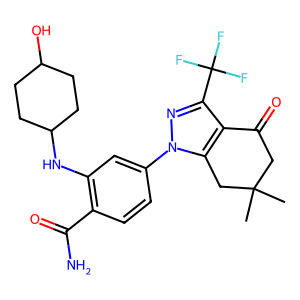

In [21]:
sample_smile = drug_df.loc['SNX-2112'][2]
print('Drug Name: SNX-2112')
print(f"SMILE: {sample_smile}\n")

mol = Chem.MolFromSmiles(sample_smile)
display(Draw.MolToImage(mol))

In [27]:
# mol_3d = AllChem.AddHs(mol, addCoords=True)
# AllChem.EmbedMolecule(mol_3d)
# Chem.rdForceFieldHelpers.MMFFOptimizeMolecule(mol_3d)
# view = py3Dmol.view(data=Chem.MolToMolBlock(mol_3d),
#                     style={"stick": {}, "sphere": {"scale": 0.3}})
# view.zoomTo()
# view.show()

In [23]:
# genetic_df = pd.read_csv(pancreatic_cancer, skiprows=1, header=None)
genetic_df = pd.read_csv(pancreatic_cancer)
genetic_df


,Drug name,Drug Id,Cell line name,Cosmic sample Id,TCGA classification,Tissue,Tissue sub-type,IC Result ID,IC50,AUC,Max conc,RMSE,Z score,Dataset version
0,Erlotinib,1,MC-CAR,683665,MM,blood,haematopoietic_neoplasm_other,112389,2.436586,0.982484,2.0,0.021894,-0.013193,17
1,Erlotinib,1,ES3,684055,UNCLASSIFIED,bone,ewings_sarcoma,46076,3.342826,0.984986,2.0,0.030357,0.777474,17
2,Erlotinib,1,ES5,684057,UNCLASSIFIED,bone,ewings_sarcoma,46573,3.571787,0.982939,2.0,0.031807,0.977236,17
3,Erlotinib,1,ES7,684059,UNCLASSIFIED,bone,ewings_sarcoma,47103,3.185231,0.984292,2.0,0.094084,0.639977,17
4,Erlotinib,1,EW-11,684062,UNCLASSIFIED,bone,ewings_sarcoma,49007,2.462555,0.946649,2.0,0.087727,0.009464,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224505,Pevonedistat,1529,SNU-407,1660034,COREAD,digestive_system,large_intestine,199227,-0.278601,0.827363,1.0,0.051694,-0.318022,17
224506,Pevonedistat,1529,SNU-61,1660035,COREAD,digestive_system,large_intestine,199956,3.013436,0.976436,1.0,0.040406,1.846470,17
224507,Pevonedistat,1529,SNU-81,1660036,COREAD,digestive_system,large_intestine,200136,0.577129,0.879707,1.0,0.098300,0.244615,17
224508,Pevonedistat,1529,SNU-C5,1674021,COREAD,digestive_system,large_intestine,200824,-0.452981,0.817504,1.0,0.038303,-0.432675,17


In [26]:
cell_line_df = pd.read_csv(ccle, index_col=0, header=0)
cell_line_df


,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.000000,0.275007,0.0,0.000000,0.000000
ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.000000,0.084064,0.0,0.000000,0.042644
ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.000000,0.028569,0.0,0.000000,0.000000
ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.000000,0.464668,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000285,0.056584,0.000000,6.604071,3.264536,4.972693,0.411426,0.097611,0.704872,4.829850,5.178715,...,2.229588,0.084064,1.310340,3.039138,0.344828,0.000000,0.000000,0.0,0.475085,0.042644
ACH-002669,3.109361,0.000000,7.031219,1.541019,3.664483,0.014355,3.624101,6.805292,4.472488,4.397118,...,0.189034,0.400538,0.356144,1.327687,0.000000,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001858,4.390943,0.000000,7.013127,1.887525,3.252476,0.028569,3.286881,6.902074,5.410748,3.401903,...,1.097611,0.400538,0.613532,1.992768,0.704872,0.000000,1.464668,0.0,0.000000,0.526069
ACH-001997,5.057017,0.000000,7.814935,2.538538,3.893362,0.028569,4.078951,6.971429,4.469886,3.463361,...,0.831877,0.847997,1.292782,2.153805,0.687061,0.000000,0.000000,0.0,0.000000,0.000000


In [25]:
landmark_genes_df = pd.read_csv(landmark_genes, sep= '\t', header=0)
landmark_genes_df


,Entrez ID,Symbol,Name,Gene Family,Type,RNA-Seq Correlation,RNA-Seq Correlation Self-Rank
0,16,AARS,alanyl-tRNA synthetase,"Aminoacyl tRNA synthetases, Class II",landmark,NaN,NaN
1,10058,ABCB6,ATP binding cassette subfamily B member 6 (Lan...,"Blood group antigens, ATP binding cassette sub...",landmark,NaN,NaN
2,10057,ABCC5,ATP binding cassette subfamily C member 5,ATP binding cassette subfamily C,landmark,NaN,NaN
3,23,ABCF1,ATP binding cassette subfamily F member 1,ATP binding cassette subfamily F,landmark,NaN,NaN
4,55324,ABCF3,ATP binding cassette subfamily F member 3,ATP binding cassette subfamily F,landmark,NaN,NaN
...,...,...,...,...,...,...,...
973,55893,ZNF395,zinc finger protein 395,Zinc fingers C2H2-type,landmark,NaN,NaN
974,26036,ZNF451,zinc finger protein 451,Zinc fingers C2H2-type,landmark,NaN,NaN
975,54807,ZNF586,zinc finger protein 586,Zinc fingers C2H2-type,landmark,NaN,NaN
976,51385,ZNF589,zinc finger protein 589,Zinc fingers C2H2-type,landmark,NaN,NaN


In [24]:
samples = pd.read_csv(bio_sample_info, header = 0)
samples


,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
0,ACH-000016,SLR 21,SLR21,SLR21_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_V607,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-JnARLB,NaN,Clear cell renal cell carcinoma,C4033,NaN
1,ACH-000032,MHH-CALL-3,MHHCALL3,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Female,DSMZ,CVCL_0089,NaN,...,b_cell,NaN,NaN,NaN,NaN,PT-p2KOyI,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
2,ACH-000033,NCI-H1819,NCIH1819,NCIH1819_LUNG,NaN,NaN,Female,Academic lab,CVCL_1497,NaN,...,NSCLC_adenocarcinoma,NaN,NaN,NaN,NaN,PT-9p1WQv,NaN,Lung adenocarcinoma,C3512,NaN
3,ACH-000043,Hs 895.T,HS895T,HS895T_FIBROBLAST,NaN,NaN,Female,ATCC,CVCL_0993,NaN,...,NaN,NaN,2D: adherent,NaN,NaN,PT-rTUVZQ,NaN,Melanoma,C3224,NaN
4,ACH-000049,HEK TE,HEKTE,HEKTE_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_WS59,NaN,...,NaN,NaN,NaN,immortalized,NaN,PT-qWYYgr,NaN,NaN,NaN,No information is available about this cell li...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,ACH-002393,CRO-AP3,CROAP3,CROAP3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,Sanger,CVCL_1810,NaN,...,b_cell_primary_effusion,NaN,NaN,NaN,NaN,PT-TC0lZM,NaN,Primary effusion lymphoma,C6915,NaN
1836,ACH-002394,GEO,GEO,GEO_LARGE_INTESTINE,NaN,NaN,NaN,Sanger,CVCL_0271,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-Fa1q9q,NaN,Colon carcinoma,C4910,NaN
1837,ACH-002395,HuH-6 Clone 5,HUH6CLONE5,HUH6CLONE5_LIVER,NaN,NaN,Male,Sanger,CVCL_1296,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-TtIXsL,ACH-000671,Hepatoblastoma,C3728,NaN
1838,ACH-002396,Sarc9371,SARC9371,SARC9371_BONE,NaN,NaN,NaN,Sanger,CVCL_5G89,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-715FdC,NaN,Osteosarcoma,C9145,NaN
